In [10]:
!pip install datasets transformers torch soundfile evaluate accelerate matplotlib torchaudio fastapi uvicorn huggingface_hub librosa

In [11]:
from datasets import load_dataset

# Load the GTZAN dataset
gtzan = load_dataset("marsyas/gtzan", "all")

In [12]:
# Perform a 90/10 train-test split
gtzan = gtzan["train"].train_test_split(seed=42, test_size=0.1)

# Verify the dataset structure
print(gtzan)

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 899
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 100
    })
})


In [13]:
from datasets import Audio

# Resample audio to 16 kHz
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=16000))

In [14]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

# Load the pretrained model and feature extractor
model_name = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels=10,  # 10 music genres
    label2id={label: i for i, label in enumerate(gtzan["train"].features["genre"].names)},
    id2label={i: label for i, label in enumerate(gtzan["train"].features["genre"].names)}
)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def preprocess_function(examples):
    audio = examples["audio"]
    inputs = feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=True,
        padding="max_length",
        max_length=16000 * 30,  # 30 seconds
        truncation=True
    )
    return {
        "input_values": inputs.input_values[0],
        "attention_mask": inputs.attention_mask[0],
        "label": examples["genre"]
    }

# Apply preprocessing to the dataset
train_data = gtzan["train"].map(preprocess_function, remove_columns=["audio"])
test_data = gtzan["test"].map(preprocess_function, remove_columns=["audio"])

In [16]:
from transformers import Trainer, TrainingArguments
import evaluate
import numpy as np

# Define the accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./distilhubert-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    gradient_checkpointing=True,
    fp16=True,  # Enable mixed precision training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")

/opt/saturncloud/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1101/383987261.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.978000,1.480337,0.600000
2,1.381600,1.032211,0.720000
3,1.037800,0.978607,0.750000
4,0.774800,0.767391,0.740000
5,0.607400,0.643422,0.810000
6,0.507500,0.594797,0.770000
7,0.389900,0.587798,0.830000
8,0.238700,0.533143,0.820000
9,0.192700,0.560058,0.830000
10,0.153200,0.555438,0.830000


Accuracy: 0.83


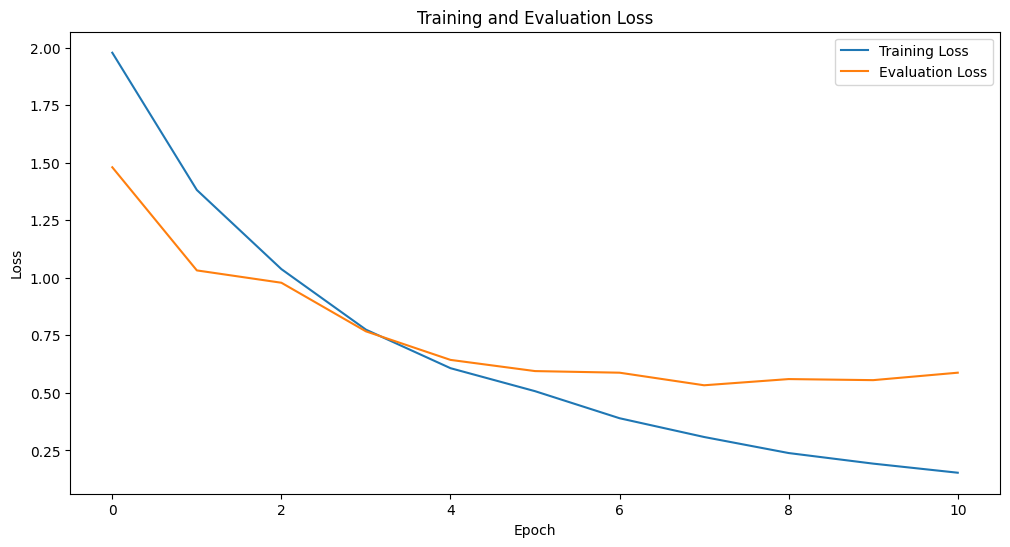

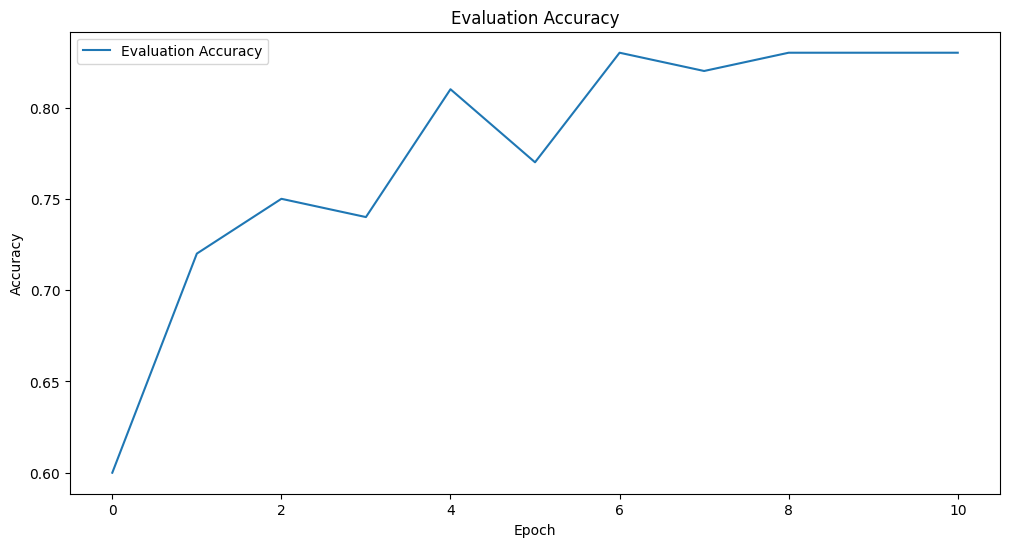

In [17]:
import matplotlib.pyplot as plt

# Extract training and evaluation metrics
train_loss = [x["loss"] for x in trainer.state.log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in trainer.state.log_history if "eval_loss" in x]
eval_accuracy = [x["eval_accuracy"] for x in trainer.state.log_history if "eval_accuracy" in x]

# Plot training and evaluation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Evaluation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.show()

# Plot evaluation accuracy
plt.figure(figsize=(12, 6))
plt.plot(eval_accuracy, label="Evaluation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.show()

In [18]:
# Save the model and feature extractor locally
model.save_pretrained("./distilhubert-finetuned-gtzan")
feature_extractor.save_pretrained("./distilhubert-finetuned-gtzan")

['./distilhubert-finetuned-gtzan/preprocessor_config.json']